# Simple spheres data processing 

### Setup

#### Ensuring Reproducibility with Seeds




In [2]:
seed_value=42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from tqdm.auto import trange

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, f_regression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization, Input, Activation, Concatenate, Dropout
from tensorflow.keras import layers, optimizers, callbacks, Model
from keras.initializers import zeros

from scipy.signal import find_peaks

import keras_tuner as kt
from keras import backend as K

from miniMie import Mie_spectrum

In [4]:
plt.rcParams.update({
   "font.family": "serif",  # use serif/main font for text elements
   "text.usetex": True,     # use inline math for ticks
   "pgf.rcfonts": False     # don't setup fonts from rc parameters
   })

# Read and display data

In [84]:
df1=pd.read_csv(r'spheres_dataset.csv')
df1

,radius,refractive index,Ext. maxima,wavelgth ext. max.,Sca. maxima,wavelgth sca. max.,Abs. maxima,wavelgth abs. max.,EF. maxima,wavelgth ef. max.
0,20.0,1.00,1.280937,516.0,0.043212,522.0,1.241792,514.0,1.018941,508.0
1,20.0,1.05,1.546413,520.0,0.057436,522.0,1.490329,518.0,1.026474,418.0
2,20.0,1.10,1.853285,520.0,0.075461,526.0,1.779933,520.0,1.033442,520.0
3,20.0,1.15,2.174521,520.0,0.098606,532.0,2.081695,520.0,1.039943,526.0
4,20.0,1.20,2.506169,522.0,0.128139,536.0,2.387432,522.0,1.046219,534.0
...,...,...,...,...,...,...,...,...,...,...
436,100.0,1.80,5.710937,696.0,4.361668,694.0,1.596705,614.0,2.843320,700.0
437,100.0,1.85,5.667940,708.0,4.351912,706.0,1.598348,624.0,2.774940,714.0
438,100.0,1.90,5.620068,760.0,4.315172,718.0,1.623708,666.0,2.685431,726.0
439,100.0,1.95,5.587177,776.0,4.280363,732.0,1.651854,676.0,2.602430,740.0


# Meaningful representation learning with VAE

## Data Preprocessing and Splitting

The script below is preparing the dataset for the modeling process. It begins by selecting different subsets from the dataframe `df` for observations (`Obs`), questions (`Qst`), and answers (`Ans`).

- `Obs` represents the optical and geometrical features of the spheres. The goal is for the model to reconstruct results similar to these observations from a given question.
- `Qst` refers to the optical property `wavelength ext. max.`. This is the variable provided to the decoder to generate an answer.
- `Ans` contains the `radius` and the `refractive index` of the spheres. These are the variables that the model aims to predict.


In [6]:
Obs=df[['radius','refractive index','wavelgth ext. max.']]
Qst=df[['wavelgth ext. max.']]
Ans=df.iloc[:,0:2]
Obs_train, Obs_test, Qst_train, Qst_test, Ans_train, Ans_test = train_test_split(Obs, Qst, Ans, test_size=0.2, random_state=42)

## Building of the autoencoder

This script below is constructing an unsupervised learning model that learns to represent and generate data by encoding it into a lower-dimensional latent space.

1. **Sampling Layer**: The Sampling layer is a custom layer used to generate a sample from the normal distribution $\mathcal{N}(\mu, \log(\sigma))$ of the learned latent representation. 

2. **Encoder Definition**: This section defines the architecture of the encoder part of the VAE. It passes the inputs through a dense layer, and finally uses two separate dense layers to output the mean $\mu$ and log variance $\log(\sigma)$ of the latent distribution. The Sampling layer then uses these to generate the encoded latent variable.

3. **Decoder Definition**: The decoder part of the VAE is defined next. It takes as input the latent variable from the encoder and a question (optical properties). These are concatenated and passed through a dense layer to reconstruct the geometrical features (answers).

4. **VAE Model**: The encoder and decoder are combined into the final VAE model, which takes the original inputs and the question as input and outputs the reconstructed data.

5. **Latent Loss**: The latent loss, also known as the KL divergence, is calculated. It quantifies the difference between the learned latent distribution and the prior (standard normal distribution). It is calculated using the following formula: 

    $$
    D_{K L}\left(q_\phi(\boldsymbol{z} \mid \boldsymbol{x}) \| p_\psi(\boldsymbol{z} \mid \boldsymbol{x})\right)=\sum_i \log \left(\sigma_i^2\right)-\mu_i^2-\sigma_i^2
    $$ 

    This loss is added to the recontruction loss to enforce the structure of the latent space. 

    A beta hyperparameter is introduced. It controls the trade-off between two objectives: (1) how accurately the model can reconstruct the observation data, and (2) how closely the latent variables match a unit Gaussian distribution.



6. **Compilation and Training**: Learning rate reduction is used as a callback during training to adjust the learning rate when the validation loss plateaus. This is called a performance scheduling of the learning rate. 


In [7]:
#Defining the sampling layer
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [69]:
#build
#encoder
beta=5e-2
codings_size = 1
inputs = Input(shape=[3])
norm_codings = Normalization()
Z=norm_codings(inputs)
Z = Dense(2, activation="swish",kernel_initializer=tf.keras.initializers.HeNormal(seed=seed_value))(Z)
Z = Dropout(1e-3,seed=seed_value)(Z)
codings_mean = Dense(codings_size)(Z) # μ
codings_log_var = Dense(codings_size,kernel_initializer=zeros())(Z) # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

#decoder
question_inputs = Input(shape=[1])
norm_question = Normalization()
q=norm_question(question_inputs)
decoder_inputs = Input(shape=[codings_size]) 
x= Concatenate()([decoder_inputs, q])
x = Dense(2, activation="swish",kernel_initializer=tf.keras.initializers.HeNormal(seed=-seed_value))(x)
#x = Dropout(1e-3,seed=seed_value)(x)
outputs = Dense(2)(x) #Answer size
variational_decoder = Model(inputs=[question_inputs,decoder_inputs], outputs=[outputs])

#VAE
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(inputs=[question_inputs,codings])
variational_ae = Model(inputs=[inputs,question_inputs], outputs=[reconstructions])

#latent loss
latent_loss = -beta*0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 2.)

#compile and train
variational_ae.compile(loss="mse", optimizer=optimizers.Adam(1e-2))
norm_codings.adapt(Obs)
norm_question.adapt(Qst)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=500)
history = variational_ae.fit((Obs,Qst), Ans, epochs=10000,validation_split=0.2,batch_size=1,callbacks=[lr_scheduler],verbose=False)

### Learning process through epochs

3/3 [==============================] - 0s 950us/step


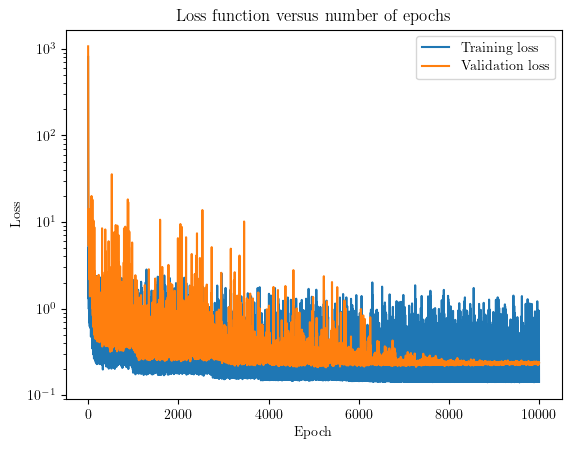

RMSE 0.4088701155967604 MAE 0.15102690545360692


In [70]:
#evaluate
mse_ivaec = variational_ae.evaluate((Obs_test,Qst_test), Ans_test)
rmse_ivaec=np.sqrt(mse_ivaec)
mae_ivaec=mean_absolute_error(Ans_test,variational_ae.predict((Obs_test,Qst_test)))
rmse_ivaec,mae_ivaec


plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Loss function versus number of epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss','Validation loss'])
plt.show()

print('RMSE',rmse_ivaec,'MAE',mae_ivaec)


### Performance scheduling

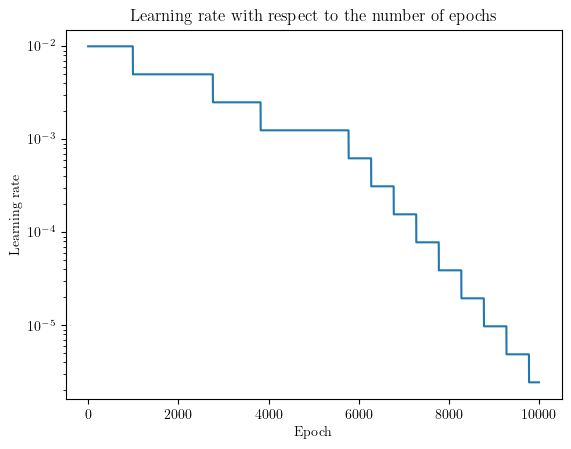

In [71]:
plt.semilogy(history.history["lr"])
plt.title('Learning rate with respect to the number of epochs')
plt.ylabel('Learning rate')
plt.xlabel('Epoch')
plt.show()

### Statistical properties

Here can be observed the distribution of the latent space. The higher the value of $\beta$, the more significant and restrictive the latent loss becomes during training, thus causing the latent space to more closely resemble a normal distribution, $\mathcal{N}(\mu=0,\sigma=1)$. In this case, $\mu\sim0.6$ and $\sigma\sim1.2$. 

Two vectors, $z^{\prime}$ and $z^{\prime\prime}$, from the latent space were generated from the encoding of the same observation set. As can be seen, the two vectors are very similar but not identical. This shows the ability of the model to generate new data. This will be studied next.

14/14 [==============================] - 0s 562us/step


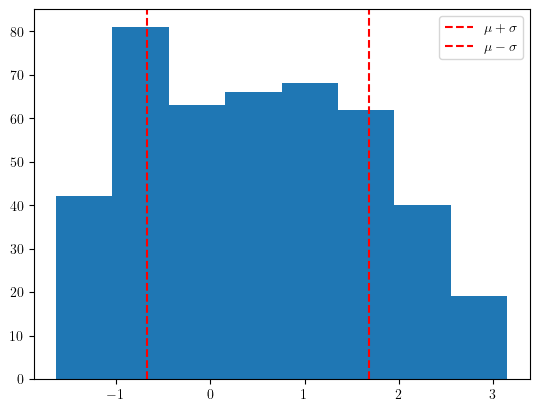

Mean 0.5041667 Standard deviation 1.1823709


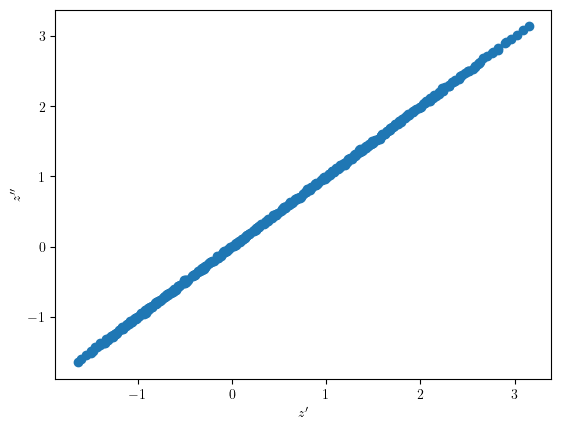

In [72]:
z=np.array(variational_encoder.predict(Obs))[2,:]
zalt=np.array(variational_encoder.predict(Obs))[2,:]
z=z.ravel()
zalt=zalt.ravel()


plt.figure()
plt.hist(z,bins=8)
plt.axvline(x=np.mean(z)+np.std(z),color='r',linestyle='--',label='$\mu+\sigma$')
plt.axvline(x=np.mean(z)-np.std(z),color='r',linestyle='--',label='$\mu-\sigma$')
plt.legend()
plt.show()

print('Mean',np.mean(z),'Standard deviation',np.std(z))

plt.figure()
plt.scatter(z,zalt)
plt.xlabel('$z^{\prime}$')
plt.ylabel('$z^{\prime\prime}$')
plt.show()

### Statistical Metrics

The script computes and prints out two key statistical measures: the linear correlation coefficient and the F-statistic.

In [73]:
corr_lin_score=np.corrcoef(z,zalt)
F_score,_=f_regression(z.reshape(-1,1),zalt)
print('Correlation coefficient',corr_lin_score[0,1],'F test',F_score)

Correlation coefficient 0.9999528576894714 F test [4664870.95491891]


### Normalized distance information

The question arises: how different are the generated data? Are they sharing the same information? If the vectors are too close, the model may not be able to generate new data. Conversely, if the vectors are too far apart, the model may not generate anything relevant. There is a trade-off to find. To measure this, we use the normalized distance information:

$$
D I=1-\frac{M I(X ; Y)}{\max \{H(X), H(Y)\}}
$$

This measure is equal to 1 when the two variables are independent, and 0 when they are identical. $MI(X;Y)$ represents the mutual information between the two variables $X$ and $Y$, and $H(X)$ and $H(Y)$ denote the entropies of $X$ and $Y$, respectively. The mutual information and the entropies are calculated using the `mutual_info_regression` function from scikit-learn. Another metric that could be utilized is the normalized variation of information:

$$V I=1-\frac{M I(X ; Y)}{ H(X,Y)}=1-\frac{M I(X ; Y)}{ H(X)+H(Y)-M I(X ; Y)}$$


In [74]:
def info_dist(z1, z2, n_neighbors=1):
    """
    This function calculates the 'information distance' between two 1D arrays, `z1` and `z2`.

    Arguments:
    z1, z2 -- 1D numpy arrays; the two arrays for which the information distance is calculated
    n_neighbors -- integer; number of neighbors for mutual_info_regression, defaults to 1

    Returns:
    The information distance between `z1` and `z2`.
    """
    
    # Compute mutual information
    mi_z1_z2 = mutual_info_regression(z1.reshape(-1, 1), z2, n_neighbors=n_neighbors)
    mi_z1_z1 = mutual_info_regression(z1.reshape(-1, 1), z1, n_neighbors=n_neighbors)
    mi_z2_z2 = mutual_info_regression(z2.reshape(-1, 1), z2, n_neighbors=n_neighbors)

    return 1 - mi_z1_z2 / np.max([mi_z1_z1, mi_z2_z2])


def info_var(z1, z2, n_neighbors=1):
    """
    This function calculates the 'information variation' between two 1D arrays, `z1` and `z2`.

    Arguments:
    z1, z2 -- 1D numpy arrays; the two arrays for which the information variation is calculated
    n_neighbors -- integer; number of neighbors for mutual_info_regression, defaults to 1

    Returns:
    The information variation between `z1` and `z2`.
    """

    # Compute mutual information
    mi_z1_z2 = mutual_info_regression(z1.reshape(-1, 1), z2, n_neighbors=n_neighbors)
    mi_z1_z1 = mutual_info_regression(z1.reshape(-1, 1), z1, n_neighbors=n_neighbors)
    mi_z2_z2 = mutual_info_regression(z2.reshape(-1, 1), z2, n_neighbors=n_neighbors)

    return 1 - mi_z1_z2 / (mi_z1_z1 + mi_z2_z2 - mi_z1_z2)


Three measurements are performed: Firstly, the normalized distance information is calculated between $z^{\prime}$ and $z^{\prime\prime}$. Secondly, the measure is done between two answers that were generated from the same set of observations and questions. Lastly, the measurement is taken between a generated answer (from the observation and question sets) and the original answer set. The preliminary observation suggests that the generated answers tend to differ more from the original answers than they do from each other. The same observation can be made for the normalized variation of information.

In [75]:
NDI_lat=info_dist(z,zalt)
NDI_obs=info_dist(np.array(variational_ae.predict((Obs,Qst))).reshape(-1),np.array(variational_ae.predict((Obs,Qst))).reshape(-1))
NDI_obs2=info_dist(np.array(variational_ae.predict((Obs,Qst))).reshape(-1),np.array(Ans).reshape(-1))

NVI_lat=info_var(z,zalt)
NVI_obs=info_var(np.array(variational_ae.predict((Obs,Qst))).reshape(-1),np.array(variational_ae.predict((Obs,Qst))).reshape(-1))
NVI_obs2=info_var(np.array(variational_ae.predict((Obs,Qst))).reshape(-1),np.array(Ans).reshape(-1))

print('NDI between latent vectors',NDI_lat,'NDI between two generated answers',NDI_obs,'NDI between generated answers and orinal answers set',NDI_obs2)
print('NVI between latent vectors',NVI_lat,'NVI between two generated answers',NVI_obs,'NVI between generated answers and orinal answers set',NVI_obs2)

14/14 [==============================] - 0s 562us/step
NDI between latent vectors [0.21489244] NDI between two generated answers [0.27198852] NDI between generated answers and orinal answers set [0.58633205]
NVI between latent vectors [0.35376373] NVI between two generated answers [0.42434537] NVI between generated answers and orinal answers set [0.64842066]


# Nanosphere generation by iVAE

Now, the goal is to assess the quality of the generated solutions. Firstly, a function is defined that uses the decoder to generate an answer (geometrical features) to a given question. A latent vector is randomly chosen from a normal distribution $\mathcal{N}(\mu=0,\sigma=1)$. Since the latent representation is trained to resemble a normal distribution, the answer generated should be consistent (e.g., having a positive radius or a refractive index higher than 1). However, there is a small chance that the generated answer may not be consistent. If this occurs, the function will continue to generate new answers until a consistent one is produced.

In [22]:
def nsph_gen(Qst_LSPR,codings_size,consistency=None,stddev=1,mean=0):
    """
    This function generates new sample features (radius and refractive index) using a variational autoencoder decoder.
    It takes a random latent vector from a normal distribution, and a question related to the Localized Surface Plasmon Resonance (LSPR).

    Arguments:
    Qst_LSPR -- Localized Surface Plasmon Resonance related question
    codings_size -- size of the latent space
    consistency (optional) -- number of trials for generating a consistent sample, default is None which means no consistency check
    stddev (optional) -- standard deviation of the normal distribution used for generating codings, default is 1
    mean (optional) -- mean of the normal distribution used for generating codings, default is 0

    Returns:
    dGenerated -- a DataFrame containing the generated sample features (radius and refractive index)
    """
    question_LSPR=Qst_LSPR
    codings = tf.random.normal(shape=[1, codings_size],stddev=stddev,mean=mean)
    Sfeatures = variational_decoder((question_LSPR,codings)).numpy()
    dGenerated=pd.DataFrame({
            'radius':[Sfeatures[0,0]],
            'refractive index':Sfeatures[0,1],
        })
    if not consistency==None:
        cons_count=consistency
        c=0
        # Check the consistency of generated features and regenerate if necessary
        while (dGenerated['radius'][0]<20 or dGenerated['radius'][0]>100 or dGenerated['refractive index'][0]<1 or dGenerated['refractive index'][0]>2) and c<cons_count:
            dGenerated=nsph_gen(Qst_LSPR,codings_size,consistency=None)
            c+=1
    return dGenerated

In [25]:
test_gen=nsph_gen(500,codings_size,consistency=1000)
test_gen

,radius,refractive index
0,22.373541,1.248833


Here, the extinction spectra of spheres with various generated geometrical features are displayed. The red line represents the question posed to the model to obtain these features. Two relevant points can be highlighted:

1. The spectra, and thus the features, vary for the same question. This demonstrates the model's ability to generate new data.
2. The peak of each spectrum is close to the same wavelength as the question, illustrating the model's ability to answer the question accurately.

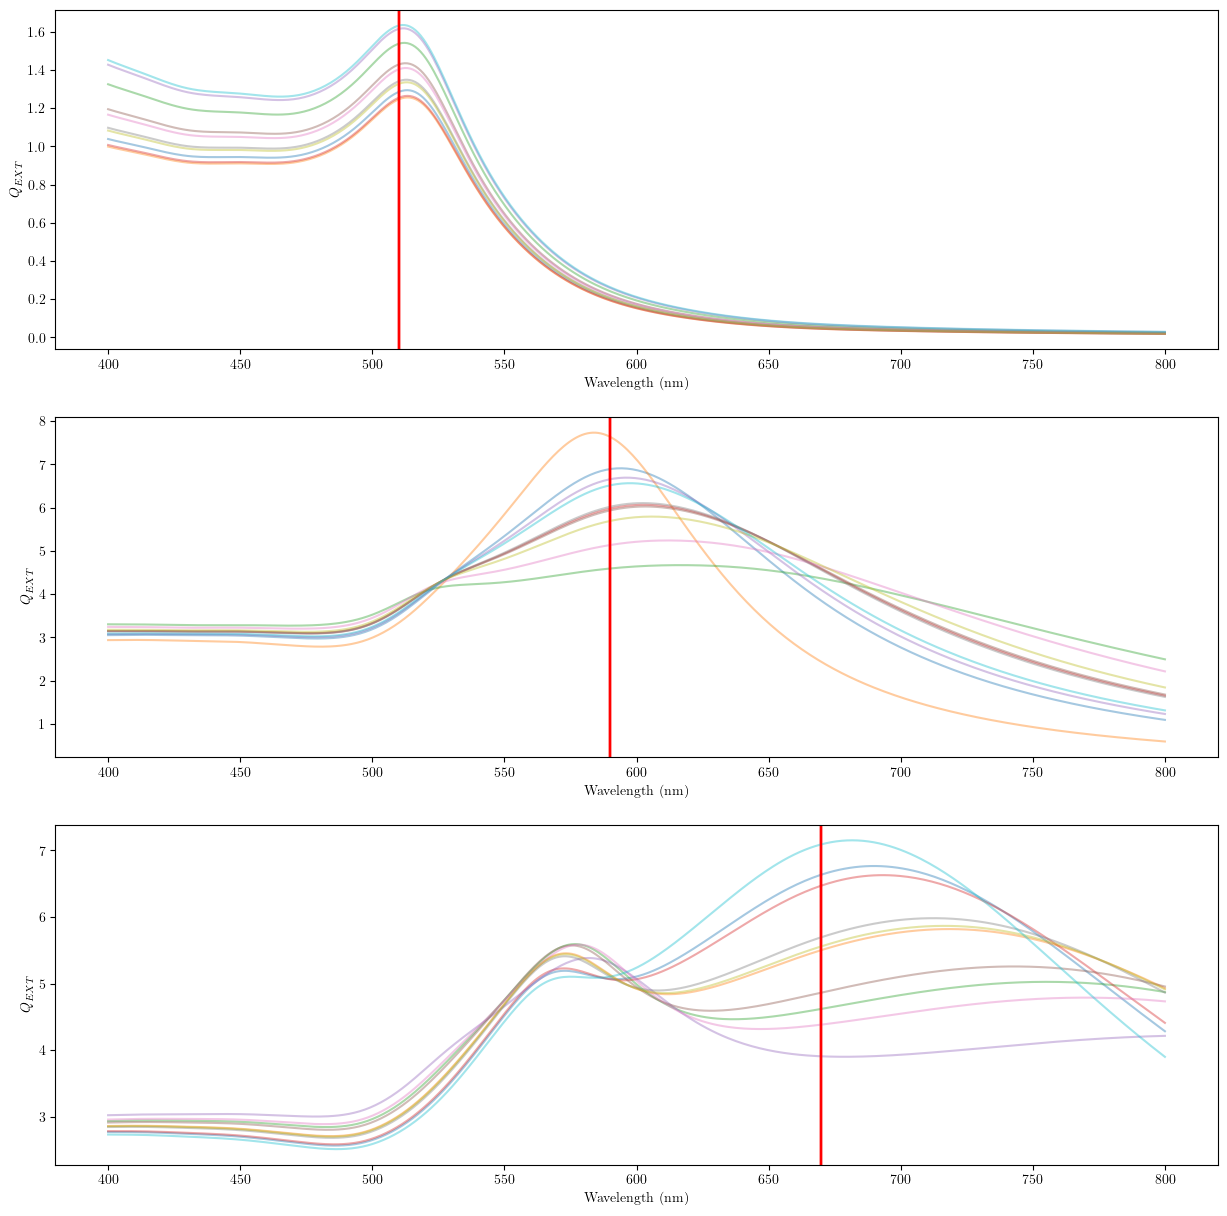

In [76]:
plt.figure(figsize=(15,15))
for i in range(10):
    dGenerated=nsph_gen(510,codings_size,consistency=1000,mean=np.mean(z),stddev=np.std(z))
    r=dGenerated['radius'][0]
    n_medium=dGenerated['refractive index'][0]
    wavelengths = np.linspace(400, 800, 400)
    (Q_ext,Q_scat)=Mie_spectrum(wavelengths,2*r,mat='gold',n_medium=n_medium)
    plt.subplot(311)
    plt.plot(wavelengths,Q_ext,alpha=0.4,label='Ext. Mie spectrum')
    plt.axvline(x=510, color='red',label='VAE predicted LSPR')
    plt.ylabel('$Q_{EXT}$')
    plt.xlabel('Wavelength (nm)')

    dGenerated=nsph_gen(590,codings_size,consistency=1000,mean=np.mean(z),stddev=np.std(z))
    r=dGenerated['radius'][0]
    n_medium=dGenerated['refractive index'][0]
    wavelengths = np.linspace(400, 800, 400)
    (Q_ext,Q_scat)=Mie_spectrum(wavelengths,2*r,mat='gold',n_medium=n_medium)
    plt.subplot(312)
    plt.plot(wavelengths,Q_ext, alpha=0.4,label='Ext. Mie spectrum')
    plt.axvline(x=590, color='red',label='VAE predicted LSPR')
    plt.ylabel('$Q_{EXT}$')
    plt.xlabel('Wavelength (nm)')

    dGenerated=nsph_gen(670,codings_size,consistency=1000,mean=np.mean(z),stddev=np.std(z))
    r=dGenerated['radius'][0]
    n_medium=dGenerated['refractive index'][0]
    wavelengths = np.linspace(400, 800, 400)
    (Q_ext,Q_scat)=Mie_spectrum(wavelengths,2*r,mat='gold',n_medium=n_medium)
    plt.subplot(313)
    plt.plot(wavelengths,Q_ext,alpha=0.4,label='Ext. Mie spectrum')
    plt.axvline(x=670, color='red',label='VAE predicted LSPR')
    plt.ylabel('$Q_{EXT}$')
    plt.xlabel('Wavelength (nm)')
plt.show()

### Error Analysis

In this section, an analysis is performed to evaluate the errors between the LSPR given by a question and the LSPR generated with an answer.

Nanospheres are generated for each $\lambda_{LSPR_{question}}$ value, which range from 500nm to 800nm, and a corresponding Mie Scattering Spectrum is created with the Mie theory, the peak in the extinction cross-section ($Q_{ext}$) is identified and the corresponding wavelength ($\lambda_{LSPR_{answer}}$) is calculated.

The error is then defined as the absolute difference between the true and predicted LSPR: $$Error = |\lambda_{LSPR_{question}} - \lambda_{LSPR_{answer}}|$$

The error as a function of the question LSPR values is illustrated in the plot.

One may see that the errors raise at 670nm.

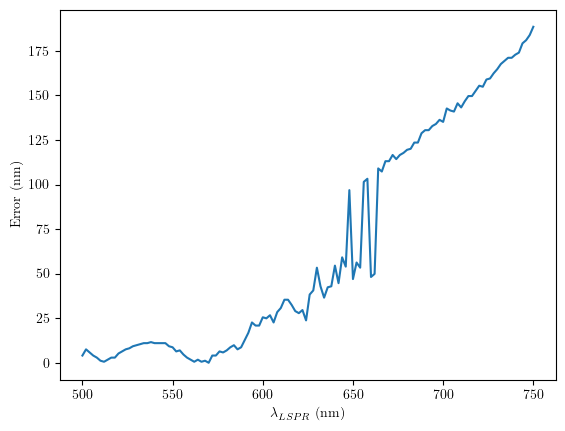

In [77]:
plt.figure()
err=[]
for i in np.linspace(500, 790, 126):
    dGenerated = nsph_gen(i, codings_size, consistency=1000,mean=np.mean(z),stddev=np.std(z)*0.1)
    r = dGenerated['radius'][0]
    n_medium = dGenerated['refractive index'][0]
    wavelengths = np.linspace(500, 790, 501)
    (Q_ext, Q_scat) = Mie_spectrum(wavelengths, 2 * r, mat='gold', n_medium=n_medium)
    peaks_ext,prop_ext=find_peaks(Q_ext)
    max_peaks_ext=peaks_ext[np.argmax(Q_ext[peaks_ext])]
    wl_mext=wavelengths[max_peaks_ext]
    err.append(np.abs(wl_mext-i))

plt.plot(np.linspace(500, 750, 126), err, alpha=1, label='Ext. Mie spectrum')
plt.xlabel('$\lambda_{LSPR}$ (nm)')
plt.ylabel('Error (nm)')
plt.show()


# Latent representation study


### Plotting Extinction Spectra for a fixed latent vector

This script generates a series of Mie Scattering Spectra by utilizing a fixed latent vector (`zfix`) and varying the question (`LSPRqst`). The LSPR span a range from 500nm to 800nm.

The extinction cross-section ($Q_{ext}$) is computed for each answer generated, using Mie theory. Each spectrum is color-coded based on its corresponding LSPR question. The spectra corresponding to questions around 500nm are coded purple, and the color transitions to yellow for questions approaching 800nm.

Changing the parameter `zfix` will generate a different set of extinction spectra.


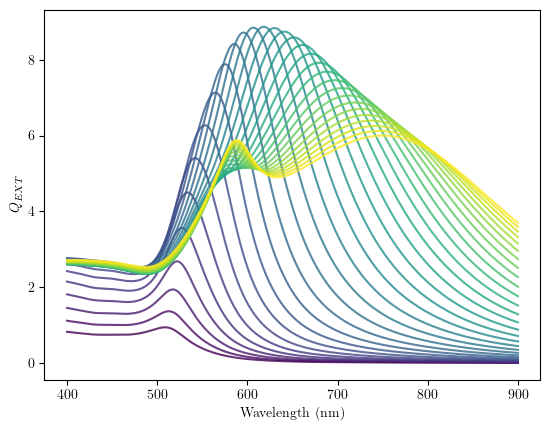

In [82]:
#chosing latent space and LSPR
zfix=np.mean(z)-np.std(z)
LSPRqst=np.linspace(500,800,31)
wavelengths = np.linspace(400, 900, 501)

norm = mcolors.Normalize(vmin=500, vmax=800) # Normalizing iteration values for the colormap
cmap = cm.ScalarMappable(norm=norm, cmap='viridis') # Creating the colormap

plt.figure()
for i in LSPRqst:
    ANSdecoded=variational_decoder((i,tf.reshape(zfix, [1]))).numpy()
    OBSdecoded=np.concatenate((ANSdecoded,np.array([[i]])),axis=1)
    zren=variational_encoder.predict(OBSdecoded,verbose=False)[0][0][0]

    (Q_ext, Q_scat) = Mie_spectrum(wavelengths, 2 * ANSdecoded[0,0], mat='gold', n_medium=ANSdecoded[0,1])
    plt.plot(wavelengths, Q_ext,color=cmap.to_rgba(i), alpha=0.8, label='Ext. Mie spectrum')

plt.ylabel('$Q_{EXT}$')
plt.xlabel('Wavelength (nm)')

plt.show()

# Latent dimension as a function of input parameters

The surface plot provides a visualization of the topography of the latent space, against radius and refractive Index.

A notable observation is that the latent space appears to be a linear combination of the geometric features. This shows that this kind of model is capable of storing a meaningful representation of the data.

In [83]:
nr=len(np.unique(Obs['radius']))
nni=len(np.unique(Obs['refractive index']))

RU=np.reshape(np.array(Obs['radius']),(nr,nni))
NI=np.reshape(np.array(Obs['refractive index']),(nr,nni))
ZSURF=np.reshape(np.array(variational_encoder.predict(Obs))[0,:],(nr,nni))

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])
fig.add_trace(go.Surface(x=RU, y=NI, z=ZSURF,showscale=False))
fig.update_layout(scene=dict(xaxis_title='radius (nm)', yaxis_title='n', zaxis_title='z'),height=600,margin=dict(l=0, r=0, t=0, b=0))
fig.show()



14/14 [==============================] - 0s 838us/step
